In [1]:
!date

Wed Jul  5 11:02:24 EDT 2023


In [2]:
pwd

'/mmfs1/data/aglinska/BC-actionpred-seg/twostream_feafa'

In [3]:
import torch
from torch.nn import functional as F
from torch import nn
from typing import Union
import numpy as np
from math import exp
import os
from os import listdir
from os.path import isfile, join
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from torchvision import models
import torch.optim as optim
import gc

from importlib import reload

import feafa_utils
import feafa_dataloader
import feafa_architecture
import feafa_criterion

reload(feafa_utils)
reload(feafa_dataloader)
reload(feafa_architecture)
reload(feafa_criterion)

<module 'feafa_criterion' from '/mmfs1/data/aglinska/BC-actionpred-seg/twostream_feafa/feafa_criterion.py'>

In [18]:
from matplotlib import pyplot as plt

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
torch.cuda.get_device_name(0)

'Tesla V100-SXM2-16GB'

In [21]:
import os, glob
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import math

def findvideofolders(path):
    folders = [os.path.join(path,folder) for folder in os.listdir(path) if not folder.startswith('.')]
    folders.sort()
    return folders


def windowmapper(videopaths,window,return_labels=False):
    allwindows_frames = []
    allwindows_labels = []
    for path in videopaths:
        os.chdir(path)
        path_frames = []
        path_labels = []

        for frame_filename in sorted(glob.glob("*.jpg")):
            framepath = os.path.join(path,frame_filename)
            
            path_frames.append(framepath)
            #this_label = framepath.split('/')[-1]
            this_label = (framepath.split('/')[-2],framepath.split('/')[-1])
            path_labels.append(this_label)
            #labelpath = framepath[:-4]+".auw"
#             if os.path.isfile(labelpath):
#                 f = open(labelpath, "r")
#                 x = f.read()
#                 y = torch.from_numpy(np.asarray([float(i) for i in x.split()]))
#                 #path_labels.append(y)
#             else:
#                 #path_labels.append("missing")
        
        for iwindow in range(len(path_frames)-window+1):
#             missing = 0
            #windowlabels = path_labels[iwindow:iwindow+window]
#             for label in windowlabels:
#                 if type(label) == str:
#                     missing+=1
#             if not missing:
            framepaths = path_frames[iwindow:iwindow+window]
            allwindows_frames.append(framepaths)
            allwindows_labels.append( path_labels[iwindow:iwindow+window] )
            #allwindows_labels.append()
            #allwindows_labels.append(torch.cat(windowlabels,dim=0))
    #print(len(path_labels))
    #print(path_labels)
    if return_labels==True:
        return allwindows_frames , allwindows_labels
    else:
        return allwindows_frames #, allwindows_labels
    

class FeafaDataset(Dataset):
    def __init__(self, path, window,usage,train=0.8,return_labels=False):
        self.path = path
        self.window = window
        #self.transform = transforms.Compose([transforms.CenterCrop(720),transforms.Resize((224,224)),transforms.ToTensor()])
        self.transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
        # find all the frames
        videopaths = findvideofolders(self.path)
        # select train or test
        if usage == 'Train':
            self.videopaths = videopaths[:math.ceil(len(videopaths)*train)]
        elif usage == 'Test':
            self.videopaths = videopaths[math.ceil(len(videopaths)*train):]
        else:
            print('Error: incorrect usage')
            
        # extract frames and labels
        if return_labels==True:
            self.allwindows_frames,self.allwindows_labels = windowmapper(self.videopaths,self.window,return_labels=True)
        else:
            self.allwindows_frames = windowmapper(self.videopaths,self.window)

    def __getitem__(self, index,return_labels=False):
        # read the frames in the window
        framepaths = self.allwindows_frames[index]
        frames = []
        for frame_path in framepaths:
            frame = Image.open(frame_path)
            if self.transform:
                frame = self.transform(frame)
            frames.append(frame)
        x = torch.stack(frames,dim=1)
        if return_labels==True:
            labels = self.allwindows_labels[index]
            sample = {'frames':x,'labels':labels}
        else:
            sample = {'frames':x,'labels':0}
            
        return sample

    def __len__(self):
        return len(self.allwindows_frames)


In [27]:
#os.environ["CUDA_VISIBLE_DEVICES"]='2'
#path = "/mmfs1/data/anzellos/data/FEAFA2"
path = '/data/aglinska/BC-actionpred-seg/Data/pytorch-data/xl_121_15_action_data_orig/train/'
window = 11
#traindataset = feafa_dataloader.FeafaDataset(path,window,usage='Train')
traindataset = FeafaDataset(path,window,usage='Train')
trainloader = DataLoader(traindataset,batch_size = 32)

In [28]:
len(trainloader)

2340

In [29]:
flownet = feafa_architecture.TinyMotionNet()
flownet.cuda()
flownet.train()

reconstructor = feafa_utils.Reconstructor()

criterion = feafa_criterion.SimpleLoss(flownet)

optimizer = optim.SGD(flownet.parameters(), lr=0.1, momentum=0.9)

#save_root = "/data/anzellos/results/twostream_feafa"
save_root = "/data/aglinska/BC-actionpred-seg/Data/02-results_twostream_feafa/test"

In [30]:
save_freq = 1                               # specify every how many epochs to save the model
loss_memory = []
epoch = 0
running_loss = 0.0
    
for i, data in enumerate(trainloader):
    
    frames = data['frames'].cuda()
    torch.cuda.empty_cache()
    flows = flownet(frames)
    t0s, reconstructed, flows_reshaped = reconstructor(frames, flows)
    print('done')
    break

done


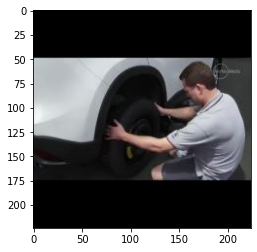

In [31]:
plt.imshow(frames[0,:,0,:,:].detach().cpu().numpy().swapaxes(0,1).swapaxes(1,2))

In [ ]:
save_freq = 1                               # specify every how many epochs to save the model
loss_memory = []
for epoch in range(5):  # loop over the dataset multiple times
    print('Starting epoch ',epoch,' ...\n')
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs
        frames = data['frames'].cuda()
        torch.cuda.empty_cache()
        flows = flownet(frames)
        t0s, reconstructed, flows_reshaped = reconstructor(frames, flows) # t0s are original images excluding the 11th, downsampled to match the reconstructed versions
        # zero the parameter gradients
        frames.detach().cpu()
        for flow in flows:
            flow.detach().cpu()
        del flows,frames
        gc.collect()
        torch.cuda.empty_cache()
        optimizer.zero_grad()
        # forward + backward + optimize
        loss = criterion(t0s,reconstructed,flows_reshaped,flownet)
        for t0 in t0s:
            t0.detach().cpu()
        for reco in reconstructed:
            reco.detach().cpu()
        for flore in flows_reshaped:
            flore.detach().cpu()
        del t0s,reconstructed,flows_reshaped
        gc.collect()
        torch.cuda.empty_cache()
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.data.item()
    epoch_loss = running_loss / len(trainloader)
    print('[%d] loss: %.3f' %(epoch + 1, epoch_loss ))
    # loss_memory.append(epoch_loss)
    running_loss = 0.0
    if epoch % save_freq == save_freq-1: 
        savename = f'epoch{epoch+1:05d}.ckp'
        save_path = os.path.join(save_root,savename)
        torch.save({
            'epoch': epoch,
            'model_state_dict': flownet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss
            }, save_path)




Starting epoch  0  ...

